In [1]:
!nvidia-smi

Sun Sep  4 13:46:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:3B:00.0 Off |                  N/A |
| 94%   87C    P2   140W / 280W |   1238MiB / 24220MiB |     76%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:86:00.0 Off |                  N/A |
|100%   

In [2]:
# config
import torch
import torch.nn as nn

# hyperparameters
class Config:
    gpu_id = 0 if torch.cuda.is_available() else -1
    device = torch.device('cuda:0') # torch.device('cpu') 
    max_seq_len = 100
    train_ratio = .8
    valid_ratio = .1
    hidden_size = 512
    output_size = 1
    num_head = 8
    num_encoder = 12
    use_leakyrelu = True
    dropout_p = .1
    learning_rate = 0.001
    grad_acc = True
    grad_acc_iter = 8

    batch_size = 64
    n_epochs = 2
    
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:0') # torch.device('cpu') 
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2
    
config = Config()

In [3]:
# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from utils import pid_diff_collate_fn

# 1. get Dataset
dataset = ASSIST2009_PID_DIFF(config.max_seq_len, idx=0, config=config)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

# 2. split Dataset
train_size = int( len(dataset) * config.train_ratio * (1 - config.valid_ratio))
valid_size = int( len(dataset) * config.train_ratio * config.valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset = Subset(dataset, range( train_size ))
valid_dataset = Subset(dataset, range( train_size, train_size + valid_size ))
test_dataset = Subset(dataset, range( train_size + valid_size, train_size + valid_size + test_size ))

# 3. get DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size = config.batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = config.batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = config.batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

In [4]:
from models.bert_ctt       import BERT_CTT
from models.cobert_ctt     import CoBERT_CTT
from models.monabert_ctt   import MonaBERT_CTT
from models.monacobert_ctt import MonaCoBERT_CTT

model_bert_ctt = BERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)

model_bert_ctt_path = '../model_records/bert4kt_plus_diff.pth'
model_dict = torch.load(model_bert_ctt_path)
model_bert_ctt.load_state_dict(model_dict['model'])

model_cobert_ctt = CoBERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)


model_cobert_ctt_path = '../model_records/convbert4kt_plus_diff.pth'
model_dict = torch.load(model_cobert_ctt_path)
model_cobert_ctt.load_state_dict(model_dict['model'])

model_mona_ctt = MonaBERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)

model_mona_ctt_path = '../model_records/monabert4kt_plus_diff.pth'
model_dict = torch.load(model_mona_ctt_path)
model_mona_ctt.load_state_dict(model_dict['model'])

model_monaco_ctt = MonaCoBERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)

model_monaco_ctt_path = '../model_records/0.8089741885505527_8_29_13_28_ctt_model.pth'
model_dict = torch.load(model_monaco_ctt_path)
model_monaco_ctt.load_state_dict(model_dict['model'])

<All keys matched successfully>

In [5]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class Tester():
    def __init__(
        self, 
        model, 
        optimizer, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
        
        # save the vis
        self.attn_dict = {head_idx : {layer_idx : [] for layer_idx in range(num_encoder)} for head_idx in range(model.encoder[0].attn.num_attention_heads)}
        
    def _save_blackbox(self, data):
        '''save attn, filter, conv_value to self'''
        
        def _hook_blackbox(attn):
            '''get attn, filter, conv_value from self.model.encoder.attn
            attn_scores : [bs, head_idx, num_seq, num_seq]
            conv_values : [bs, num_seq, head_idx, hidden_dim]
            conv_filter : [bs, num_seq, head_idx, kernel_size]
            '''
            attn_scores = attn.attn_scores 
            return {'attn' : attn_scores}
        
        # organize data, hook to easily get the attr
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              diff_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]

        attn_list = [self.model.encoder[encoder_idx].attn for encoder_idx in range(num_encoder)]
        hook_list = list(map(_hook_blackbox, attn_list))

        attn_layers = torch.stack([hook['attn'] for hook in hook_list], dim = 1) # [bs, layer_idx, head_idx, num_seq, num_seq]
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                diff = int(sample[3])
                is_mask = bool(sample[4])                
                
                if is_mask is True:
                    for encoder_idx in range(num_encoder):
                        # save attn
                        for head_idx in range(self.model.encoder[0].attn.num_attention_heads):
                            self.attn_dict[head_idx][encoder_idx] += [attn_layers[seq_idx, encoder_idx, head_idx, ...]]
                        
    def test(self, test_loader):

        auc_score = 0
        y_trues, y_scores = [], []
        loss_list = []

        with torch.no_grad():
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                y_hat = self.model(
                    q_seqs.long(),
                    mlm_r_seqs.long(),
                    pid_seqs.long(),
                    diff_seqs.long(),
                    mask_seqs.long()
                )
                
                self._save_blackbox(data)

                y_hat = y_hat.squeeze()

                y_hat = torch.masked_select(y_hat, mlm_idxs)
                correct = torch.masked_select(real_seqs, mlm_idxs)

                y_trues.append(correct)
                y_scores.append(y_hat)

        y_trues = torch.cat(y_trues).detach().cpu().numpy()
        y_scores = torch.cat(y_scores).detach().cpu().numpy()

        auc_score += metrics.roc_auc_score( y_trues, y_scores )

        loss_result = torch.mean(torch.Tensor(loss_list)).detach().cpu().numpy()

        return auc_score

In [6]:
from torch.optim import Adam
from torch.nn.functional import binary_cross_entropy

trainer_list = []
for model in [model_bert_ctt, model_cobert_ctt, model_mona_ctt, model_monaco_ctt]:
    optimizer = Adam(model.parameters(), learning_rate)
    crit = binary_cross_entropy
    trainer = Tester(
        model=model,
        optimizer=optimizer,
        n_epochs=n_epochs,
        device=device,
        num_q=num_q,
        crit=crit,
        max_seq_len=max_seq_len,
        grad_acc=grad_acc,
        grad_acc_iter=grad_acc_iter
    )
    
    trainer_list.append(trainer)

In [7]:
%%time
from einops import rearrange

attn_dict_list = []

for trainer in trainer_list:
    auc_score = trainer.test(test_loader)
    
    attn_dict_list.append(trainer.attn_dict)
    
    del trainer
    torch.cuda.empty_cache()

100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

CPU times: user 2min 34s, sys: 13.5 s, total: 2min 47s
Wall time: 2min 47s


# visualize attn score : Figure 2 - (a)

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
attn_score_list = []

model_name_list = [
    'normal attention',
    'SDC',
    'MA',
    'MA + SDC',
]

for attn_dict, model_name in zip(attn_dict_list, model_name_list):
    layer_avg = False
    head_avg  = True
    save_plot = False

    num_encoder = 1 if layer_avg else 12
    num_head = 1 if head_avg else 8

    plot_device = 'cpu'
    attn_map_list = []
    for encoder_idx in tqdm(range(num_encoder)):
        for head_idx in range(num_head):
            attn_map = torch.zeros(100, 100, device = plot_device)
            if layer_avg:
                for enc in range(12):
                    attn_map += torch.mean(torch.stack(attn_dict[head_idx][enc], dim = 0), dim = 0).to(plot_device)
            elif head_avg:
                for head in range(8):
                    attn_map += torch.mean(torch.stack(attn_dict[head][encoder_idx], dim = 0), dim = 0).to(plot_device)
            else:
                attn_map += torch.mean(torch.stack(attn_dict[head_idx][encoder_idx], dim = 0), dim = 0).to(plot_device)
            attn_map_list.append(attn_map)
            
    attn_map = torch.stack(attn_map_list, dim = 0).mean(dim = 0)
    attn_score = []
    for i in range(100):
        attn_score.append(torch.diagonal(attn_map, i).mean())
    attn_score_list.append(attn_score)

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


In [13]:
attn_score = []
for i in range(100):
    attn_score.append(torch.diagonal(attn_map, i).mean())

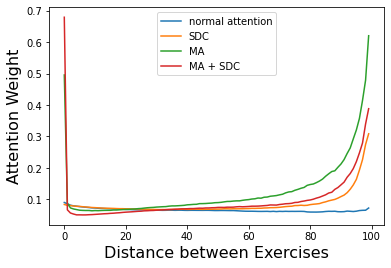

In [15]:
plt.rcParams["figure.figsize"] = (6, 4)

for attn_score, name in zip(attn_score_list, model_name_list):
    plt.plot(np.arange(100), attn_score, label = name)
plt.xlabel('Distance between Exercises', fontsize = 16)
plt.ylabel('Attention Weight', fontsize = 16)
plt.legend()
plt.savefig(f'../model_records/figure_2_a.pdf')

# visualize attn map : Figure 2 - (b)

In [13]:
import matplotlib.pyplot as plt
@torch.no_grad()
def vis_attn(
    attn_dict,
    config,
    model_name :str = 'None',
    layer_avg = False,
    head_avg  = False,
    save_plot = False,
):
    num_encoder = 1 if layer_avg else 12
    num_head = 1 if head_avg else 8
    
    fig, axs = plt.subplots(num_encoder, num_head)
    for encoder_idx in range(num_encoder):
        for head_idx in range(num_head):
            
            attn_map = torch.zeros(100, 100, device = config.device)
            if layer_avg:
                for enc in range(8):
                    attn_map += torch.mean(torch.stack(attn_dict[head_idx][enc], dim = 0), dim = 0)
            elif head_avg:
                for head in range(12):
                    attn_map += torch.mean(torch.stack(attn_dict[head][encoder_idx], dim = 0), dim = 0)
            else:
                attn_map += torch.mean(torch.stack(attn_dict[head_idx][encoder_idx], dim = 0), dim = 0)
                
            if layer_avg:
                axs[head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            elif head_avg:
                axs[encoder_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            else:
                axs[encoder_idx, head_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')                
            
    fig.suptitle(f'attn_map')
    if save_plot:
        plt.savefig(f'../model_records/attn_map-{model_name}-layer_avg-{layer_avg}-head_avg-{head_avg}.png')
    else:
        plt.show()

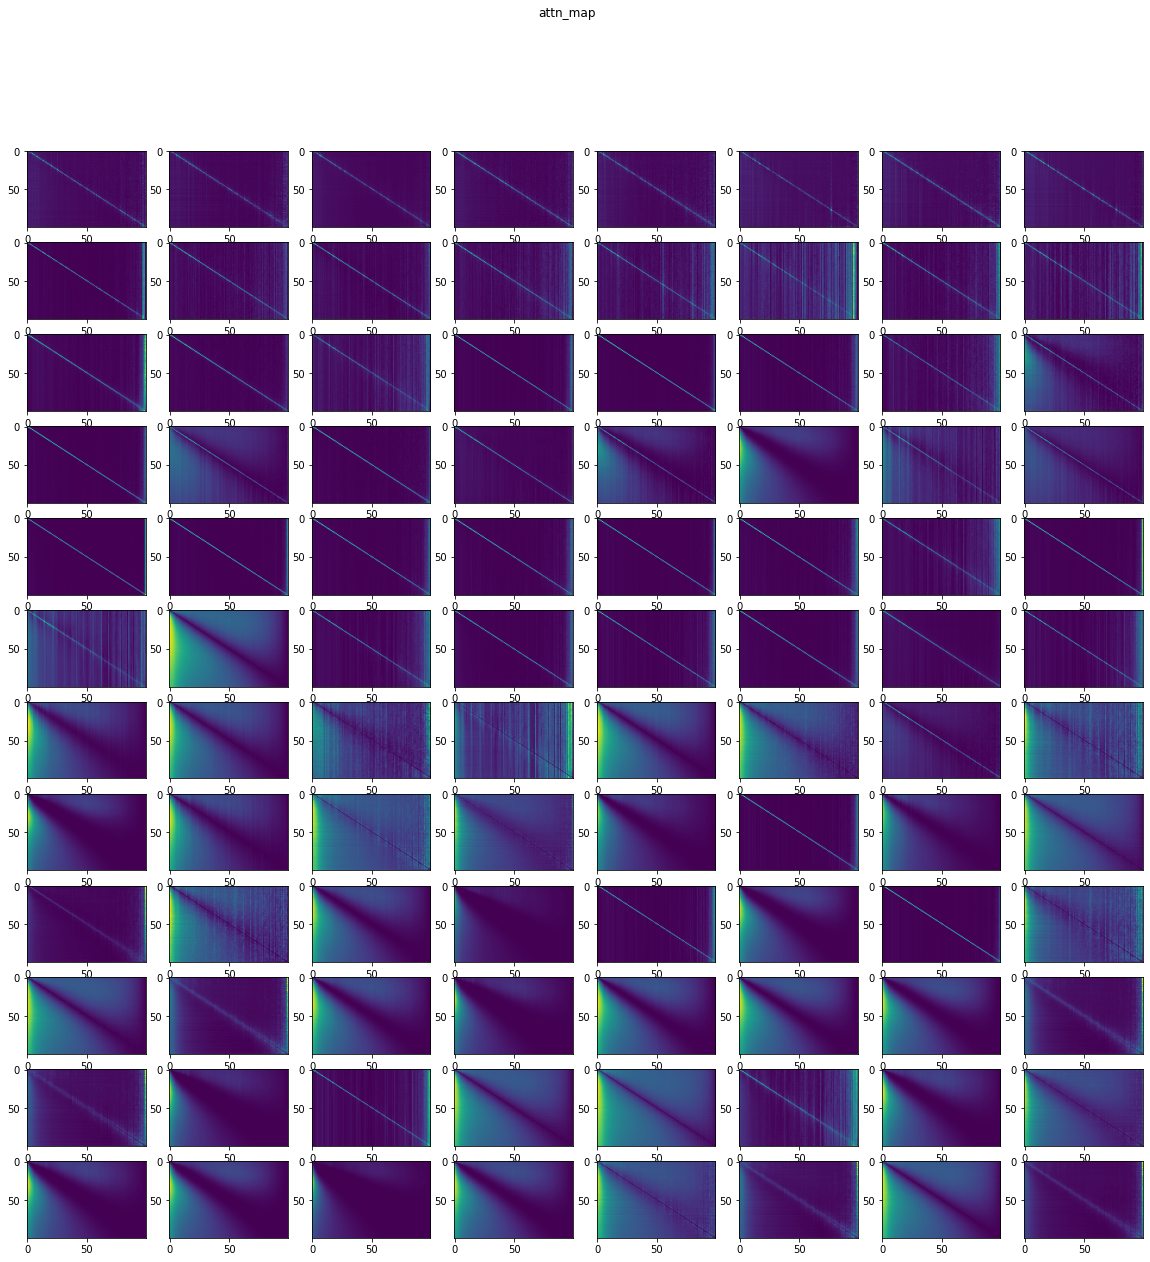

In [15]:
plt.rcParams["figure.figsize"] = (20,20)

vis_attn(
    attn_dict = trainer.attn_dict,
    config = config,
    model_name = 'model_monaco_ctt',
    layer_avg = False,
    head_avg  = False,
    save_plot = False,
)

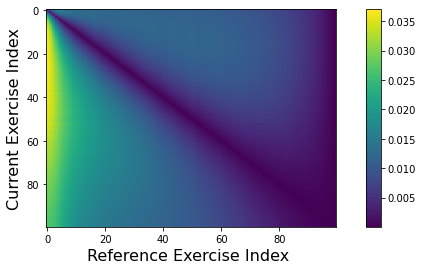

In [18]:
plt.rcParams["figure.figsize"] = (6, 4)

encoder_idxs = [5]
head_idxs = [1]

fig, (ax1, cax) = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.05]})
axs = [ax1]

attn_map_idx = 0
attn_map_list = []
for encoder_idx, head_idx in zip(encoder_idxs, head_idxs):
    attn_map = torch.zeros(100, 100, device = config.device)
    attn_map += torch.mean(torch.stack(trainer.attn_dict[head_idx][encoder_idx], dim = 0), dim = 0)
    
    im = axs[attn_map_idx].imshow(attn_map.cpu().numpy(), interpolation='antialiased', aspect='auto')
    axs[attn_map_idx].set_xlabel('Reference Exercise Index ', fontsize=16)
    
    attn_map_list.append(attn_map)
    attn_map_idx += 1

ax1.set_ylabel("Current Exercise Index", fontsize=16)
fig.colorbar(im, cax=cax)
plt.savefig(f'../model_records/figure_2_b.pdf')